<a href="https://colab.research.google.com/github/hruthiksiva/KaggleComp-IIIT-Delhi/blob/main/kaggle_iiit_round2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
import nltk
nltk.download('stopwords')
!pip install shorttext
!pip install pyenchant
!pip install unidecode contractions
#!spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 6.8MB 8.2MB/s 
     |████████████████████████████████| 24.2MB 1.6MB/s 
     |████████████████████████████████| 1.3MB 45.5MB/s 
     |████████████████████████████████| 2.9MB 43.7MB/s 
     |████████████████████████████████| 890kB 42.5MB/s 
     |████████████████████████████████| 1.1MB 38.7MB/s 
  Created wheel for shorttext: filename=shorttext-1.4.2-cp36-cp36m-linux_x86_64.whl size=607718 sha256=5e0dcccbcadf216b088651ff3d4348ed18d5dc3848bcee654949bbadbb2d0886
  Stored in directory: /root/.cache/pip/wheels/8e/c1/b9/707428f2c954c644957485a2b66980d1783c473276ba63ec5c
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ba7ec0a8959db440c00a33e0341fa3363454a344e33b94bb4abed8b045ca4fb4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 245kB 2.6MB/s 
     |████████████████████████████████| 317kB 5.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81688 sha256=55c8d8720dd6b5be2859d389c3303ac0fd557a5ea47f12ef9df0f4d9ee32c183
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import pandas as pd
import numpy as np
import random
import re
import time 
import scipy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unidecode
import contractions
from string import punctuation
import spacy
from sklearn.preprocessing import LabelEncoder

nlp = spacy.load('en_core_web_sm')

In [ ]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from keras.utils import to_categorical

In [ ]:
!ls
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sub= pd.read_csv('submission_format.csv')


sample_data  submission_format.csv  test.csv  train.csv


# **Visualize Data**

In [ ]:
train.head()

,id,content,type
0,1694628490,@avataraang awww ) where'd you get that? hugh ...,surprise
1,1751142947,@mistressmia Their is no such thing as TRANSPA...,enthusiasm
2,1695004607,"@Dojie wouldn't that cost quite a bit, I mean ...",fun
3,1752918270,Eminem's new song &quot;Beautiful&quot; is ama...,surprise
4,1751176554,"@AmyriadfthINGs Yeah, I've never seen that! Bu...",surprise


In [ ]:
train.columns

Index(['id', 'content', 'type'], dtype='object')

In [ ]:
test.head()

,id,content
0,1965378068,Dammit i just locked the keys in the car! had ...
1,1752444490,@xAnitaLx I'll do anything you like!!!!! Just ...
2,1753905153,going to watch boy in the striped pj's hope i ...
3,1752962276,It's Just So Audioo.
4,1752619727,@JamesProps very cute kitty


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       30000 non-null  int64 
 1   content  30000 non-null  object
 2   type     30000 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


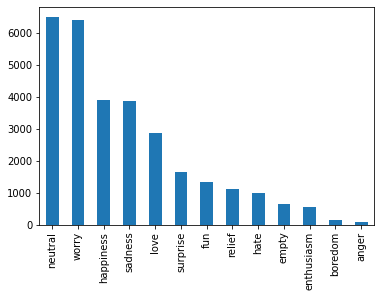

In [ ]:
train.type.value_counts().plot(kind='bar')

# **Train and Test Data**

In [ ]:
REPLACE = re.compile('[/(){}[]|@,;]')
STOPWORDS = set(stopwords.words('english'))-set(['no','not'])
def preprocess(text):
    #text = BeautifulSoup(text, "lxml").gettext(separator=' ',strip=True)
    text = text.lower()
    text = unidecode.unidecode(text)
    text=' '.join(word for word in text.split(' ') if not word.startswith('http'))
    text = ' '.join([word for word in text.split(' ') if not word.startswith('@')])
    text = REPLACE.sub(' ', text) ###
    text = ' '.join(contractions.fix(word) for word in text.split() if word not in STOPWORDS )
    text = ''.join(l for l in text if l not in punctuation if not l.isdigit())
    #text = ' '.join(spell(word) for word in text.split())
    sen  = nlp(text)
    #text = " ".join([word.lemma if word.lemma != "-PRON-" else word.lower for word in sen])
    return text.strip()

In [ ]:
train['content']=train.content.apply(preprocess)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(train.content)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train,X_test,Y_train,Y_test = train_test_split(X_train_tfidf,train.type,test_size=0.3,random_state=2020,shuffle=True)

In [ ]:
enc=LabelEncoder()
Y_train=enc.fit_transform(Y_train)
Y_train=to_categorical(Y_train, num_classes=13)

In [ ]:
test['content']=test.content.apply(preprocess)

In [ ]:
Y_train[0]

'surprise'

# **Model Selection**

## **Model1(SGD Gradient Descent)**

In [ ]:
SGDClassifier()

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model.fit(X_train,Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_train), Y_train)*100)

SVM Accuracy Score: 79.43333333333334


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 31.38888888888889


## **Model2(Naives Bayers)**

In [ ]:
Y_train

17119        worry
27843      neutral
8139         worry
22092          fun
18072         love
           ...    
11971      neutral
14966          fun
7491         empty
29064    happiness
9056       sadness
Name: type, Length: 21000, dtype: object

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

model=MultinomialNB()
model.fit(X_train,Y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

AttributeError: ignored

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_train), Y_train)*100)

SVM Accuracy Score: 45.65238095238095


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 29.06666666666667


## Model3(GradientBoosting)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train["type"].unique())
train["typelabel"]=le.transform(train["type"])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
#model = GradientBoostingClassifier(max_depth=2,subsample=0.5,n_estimators=80,learning_rate=0.19,random_state=5)
model.fit(X_train,Y_train)

## Model4(SVM)

In [ ]:
from sklearn import svm
model= svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto') #soorya highest
#model=svm.SVC(kernel='sigmoid',random_state=1)
model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)

In [ ]:
from sklearn.svm import LinearSVC
model=svm.LinearSVC()
#model=svm.SVC(kernel='sigmoid',random_state=1)
model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(Y_pred, Y_train)*100)

SVM Accuracy Score: 21.83809523809524


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 21.08888888888889


## Model5(NN)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=37957, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(13, activation='sigmoid'))

In [ ]:
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
Y_train[0]

'surprise'

In [ ]:

model.fit(X_train, Y_train, epochs=150, batch_size=64)

InvalidArgumentError: ignored

In [ ]:
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

##**Model6(XGBooster)**

In [ ]:
from xgboost import XGBClassifier
#model = XGBClassifier()
model = XGBClassifier(max_depth=5,subsample=1,n_estimators=500,learning_rate=0.08,min_child_weight=2) 
model.fit(X_train, Y_train)
Y_pred=model.predict(X_train)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(Y_pred, Y_train)*100)

SVM Accuracy Score: 43.49047619047619


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 33.666666666666664


## **Model7(Adaboosting)**

In [ ]:
!pip install AdaBoostClassifier

ERROR: Could not find a version that satisfies the requirement AdaBoostClassifier (from versions: none)
ERROR: No matching distribution found for AdaBoostClassifier


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#bmodel = DecisionTreeClassifier()
bmodel = DecisionTreeClassifier(criterion="entropy",max_depth=4)
#AdaBoost = AdaBoostClassifier(base_estimator=bmodel)
AdaBoost = AdaBoostClassifier(base_estimator=bmodel,n_estimators=20,learning_rate=0.09)
model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)

In [ ]:
np.mean(model.predict(X_train)==Y_train)

0.9251904761904762

## Model8(DecisionTree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

In [ ]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(Y_pred, Y_train)*100)

SVM Accuracy Score: 42.53809523809524


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 33.48888888888889


## **Model9(RandomForest)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model=RandomForestClassifier()
#model=RandomForestClassifier(n_estimators=100,criterion="entropy",max_depth=2)
model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)

AttributeError: ignored

## **Model10(LogisticRegression)**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=10000)),
               ])
logreg.fit(X_train, Y_train)

y_pred = logreg.predict(X_test)

AttributeError: ignored

In [ ]:
print("SVM Accuracy Score:", accuracy_score(Y_pred, Y_train)*100)

SVM Accuracy Score: 42.53809523809524


In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 33.48888888888889


# **Score Check**

In [ ]:
test['content']=test.content.apply(preprocess)

In [ ]:
X_test_counts = count_vect.transform(test.content)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(Y_pred, Y_train)*100)

In [ ]:
print("SVM Accuracy Score:", accuracy_score(model.predict(X_test), Y_test)*100)

SVM Accuracy Score: 33.92222222222222


# **Submit File Creator**

In [ ]:
sub.head()

,id,type
0,1965378068,happiness
1,1752444490,surprise
2,1753905153,enthusiasm
3,1752962276,hate
4,1752619727,neutral


In [ ]:
result.head()

,id,type
0,1965378068,neutral
1,1752444490,neutral
2,1753905153,worry
3,1752962276,neutral
4,1752619727,love


In [ ]:
result=pd.DataFrame(zip(test.id,model.predict(X_test_tfidf)),columns=['id','type'])
result.to_csv('Termi.csv',index=False,header=['id','type'])